# Node Feature Importance

In [1]:
import sys
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

path = os.path.join('..', '.')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))
    
import warnings
warnings.filterwarnings('ignore')

label_size = 12
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['figure.dpi'] = 300


In [2]:
with open('datasets/x18_exp_l2_graph_dict.pkl', 'rb') as f:
    dataset = pkl.load(f)
    
# get samples in test set
test_list = [dataset['test'][i]['graph'].dataset[0] for i in dataset['test'].keys()]

model = torch.load('../saved_models/full_model/F1=0.816_epoch=1119.pth', map_location=torch.device('cpu'))

### Gradient-based feature importance method

Gradients of the predicted class logit w.r.t. the input features

In [3]:
def compute_gradients(model, data):
    model.eval()
    data_copy = data.clone()
    data_copy.x.requires_grad_(True)

    output = model(data_copy.x, data_copy.edge_index, data_copy.edge_attr, data_copy.batch)

    pred_class = output.argmax(dim=1)
    logits_pred_class = output[0, pred_class]
    logits_pred_class.backward()

    gradients = data_copy.x.grad.clone()
    return gradients

def compute_avg_feature_importance(model, data):
    
    gradients = compute_gradients(model, data)
        
    importance_scores = torch.mean(torch.abs(gradients), dim=0)

    return importance_scores

In [4]:
feat_imps = torch.Tensor([])
for i in test_list:
    out = compute_avg_feature_importance(model, i).unsqueeze(0)
    feat_imps = torch.cat((feat_imps, out), dim=0)

In [5]:
print("Node feature importance:")
print(feat_imps[:5])

Node feature importance:
tensor([[0.1000, 0.2032, 0.1061, 0.0625, 0.0663, 0.1597, 0.0652, 0.0933, 0.0709,
         0.0693, 0.0720, 0.0923, 0.0813, 0.0848, 0.2480, 0.6936, 0.5952, 0.4893],
        [0.0820, 0.1838, 0.1005, 0.0611, 0.0599, 0.1488, 0.0546, 0.0842, 0.0652,
         0.0672, 0.0664, 0.0916, 0.0730, 0.0777, 0.2337, 0.6730, 0.5919, 0.4580],
        [0.1092, 0.2199, 0.1085, 0.0636, 0.0715, 0.1628, 0.0695, 0.1028, 0.0746,
         0.0725, 0.0819, 0.0939, 0.0787, 0.0982, 0.2641, 0.7119, 0.6079, 0.5156],
        [0.0989, 0.1983, 0.1012, 0.0592, 0.0627, 0.1535, 0.0629, 0.0885, 0.0687,
         0.0728, 0.0730, 0.0914, 0.0755, 0.0827, 0.2408, 0.6636, 0.5753, 0.4748],
        [0.1060, 0.2128, 0.1049, 0.0621, 0.0640, 0.1554, 0.0680, 0.0981, 0.0672,
         0.0759, 0.0753, 0.0907, 0.0782, 0.0965, 0.2517, 0.6797, 0.5872, 0.4961]])


In [6]:
mean_importance = feat_imps.mean(dim=0).numpy()
std_per_feature = feat_imps.std(dim=0).numpy()

print("Mean per feature:", mean_importance)
print("Std per feature:", std_per_feature)

Mean per feature: [0.09297552 0.19484329 0.10463048 0.06251553 0.06249531 0.15293232
 0.0602812  0.08944747 0.06777841 0.06963925 0.0722837  0.09289449
 0.07764319 0.08342995 0.24092516 0.68573815 0.59464544 0.47676444]
Std per feature: [0.0097442  0.01502672 0.00405114 0.00298953 0.00465715 0.00593664
 0.00606674 0.00752264 0.00443822 0.00352969 0.00540398 0.00408756
 0.00414619 0.00966736 0.01120435 0.02445753 0.01860119 0.02269426]


### Plot

In [7]:
feature_labels = [
    'Amino Acid Volume', 'Hydropathy WW', 'Mw', 'Amino Acid Pi', 'Hydropathy KD',
    'HBond Acceptors', 'HBond Donors', 'Rings', 'PZA Distance', 'phi', 'psi',
    'Residue SASA', 'Depth', 'Fe Dist', 'Snap2', 'DeepDDG', 'RaSP', 'MAPP'
]

df_feat_imps = pd.DataFrame(feat_imps.numpy(), columns=feature_labels)

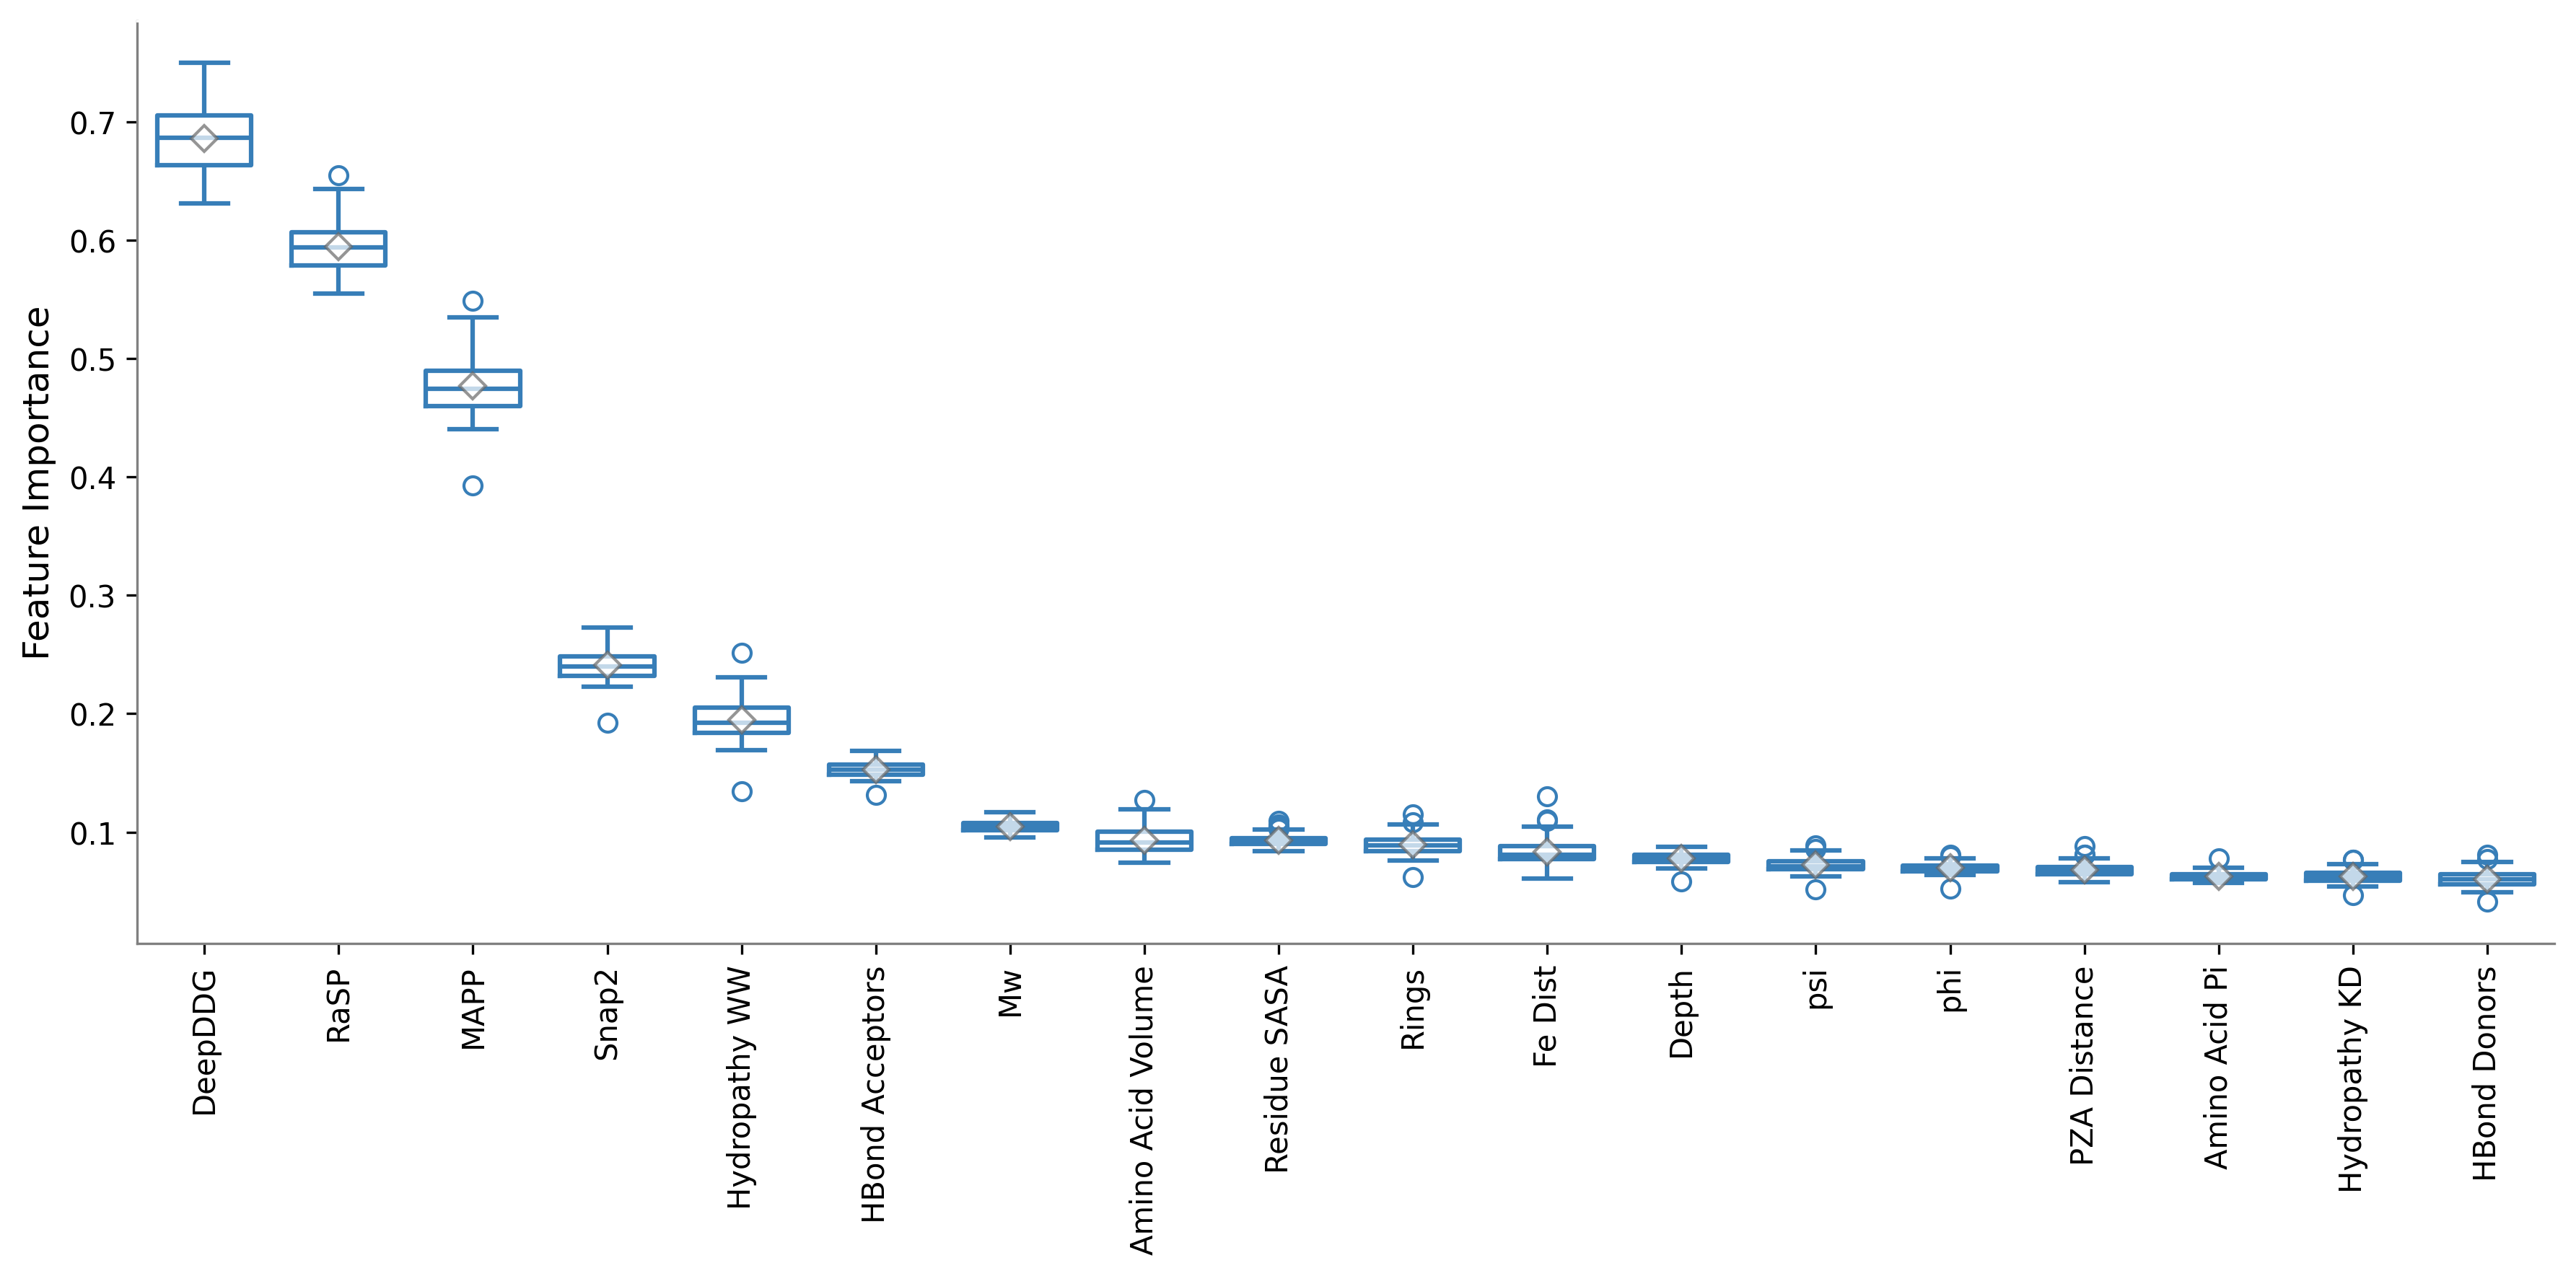

In [11]:
plt.figure(figsize=(12, 6))

# sort features by importance
sorted_indices = np.argsort(mean_importance)[::-1]
sorted_means = mean_importance[sorted_indices]
sorted_labels = [feature_labels[i] for i in sorted_indices]

box_plot = sns.boxplot(
    data=df_feat_imps[sorted_labels],
    width=0.7,
    fill=False, 
    showfliers=True, 
    showmeans=True,
    meanprops={'marker':'D', 'markerfacecolor':'white',
                       'markeredgecolor':'dimgray', 'linestyle':'--',
                       'alpha':0.7},
    color='#377eb8'
    )

plt.xticks(
    rotation=90, 
    # ha='right'
    )
plt.ylabel('Feature Importance')

plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.tight_layout()
plt.show()

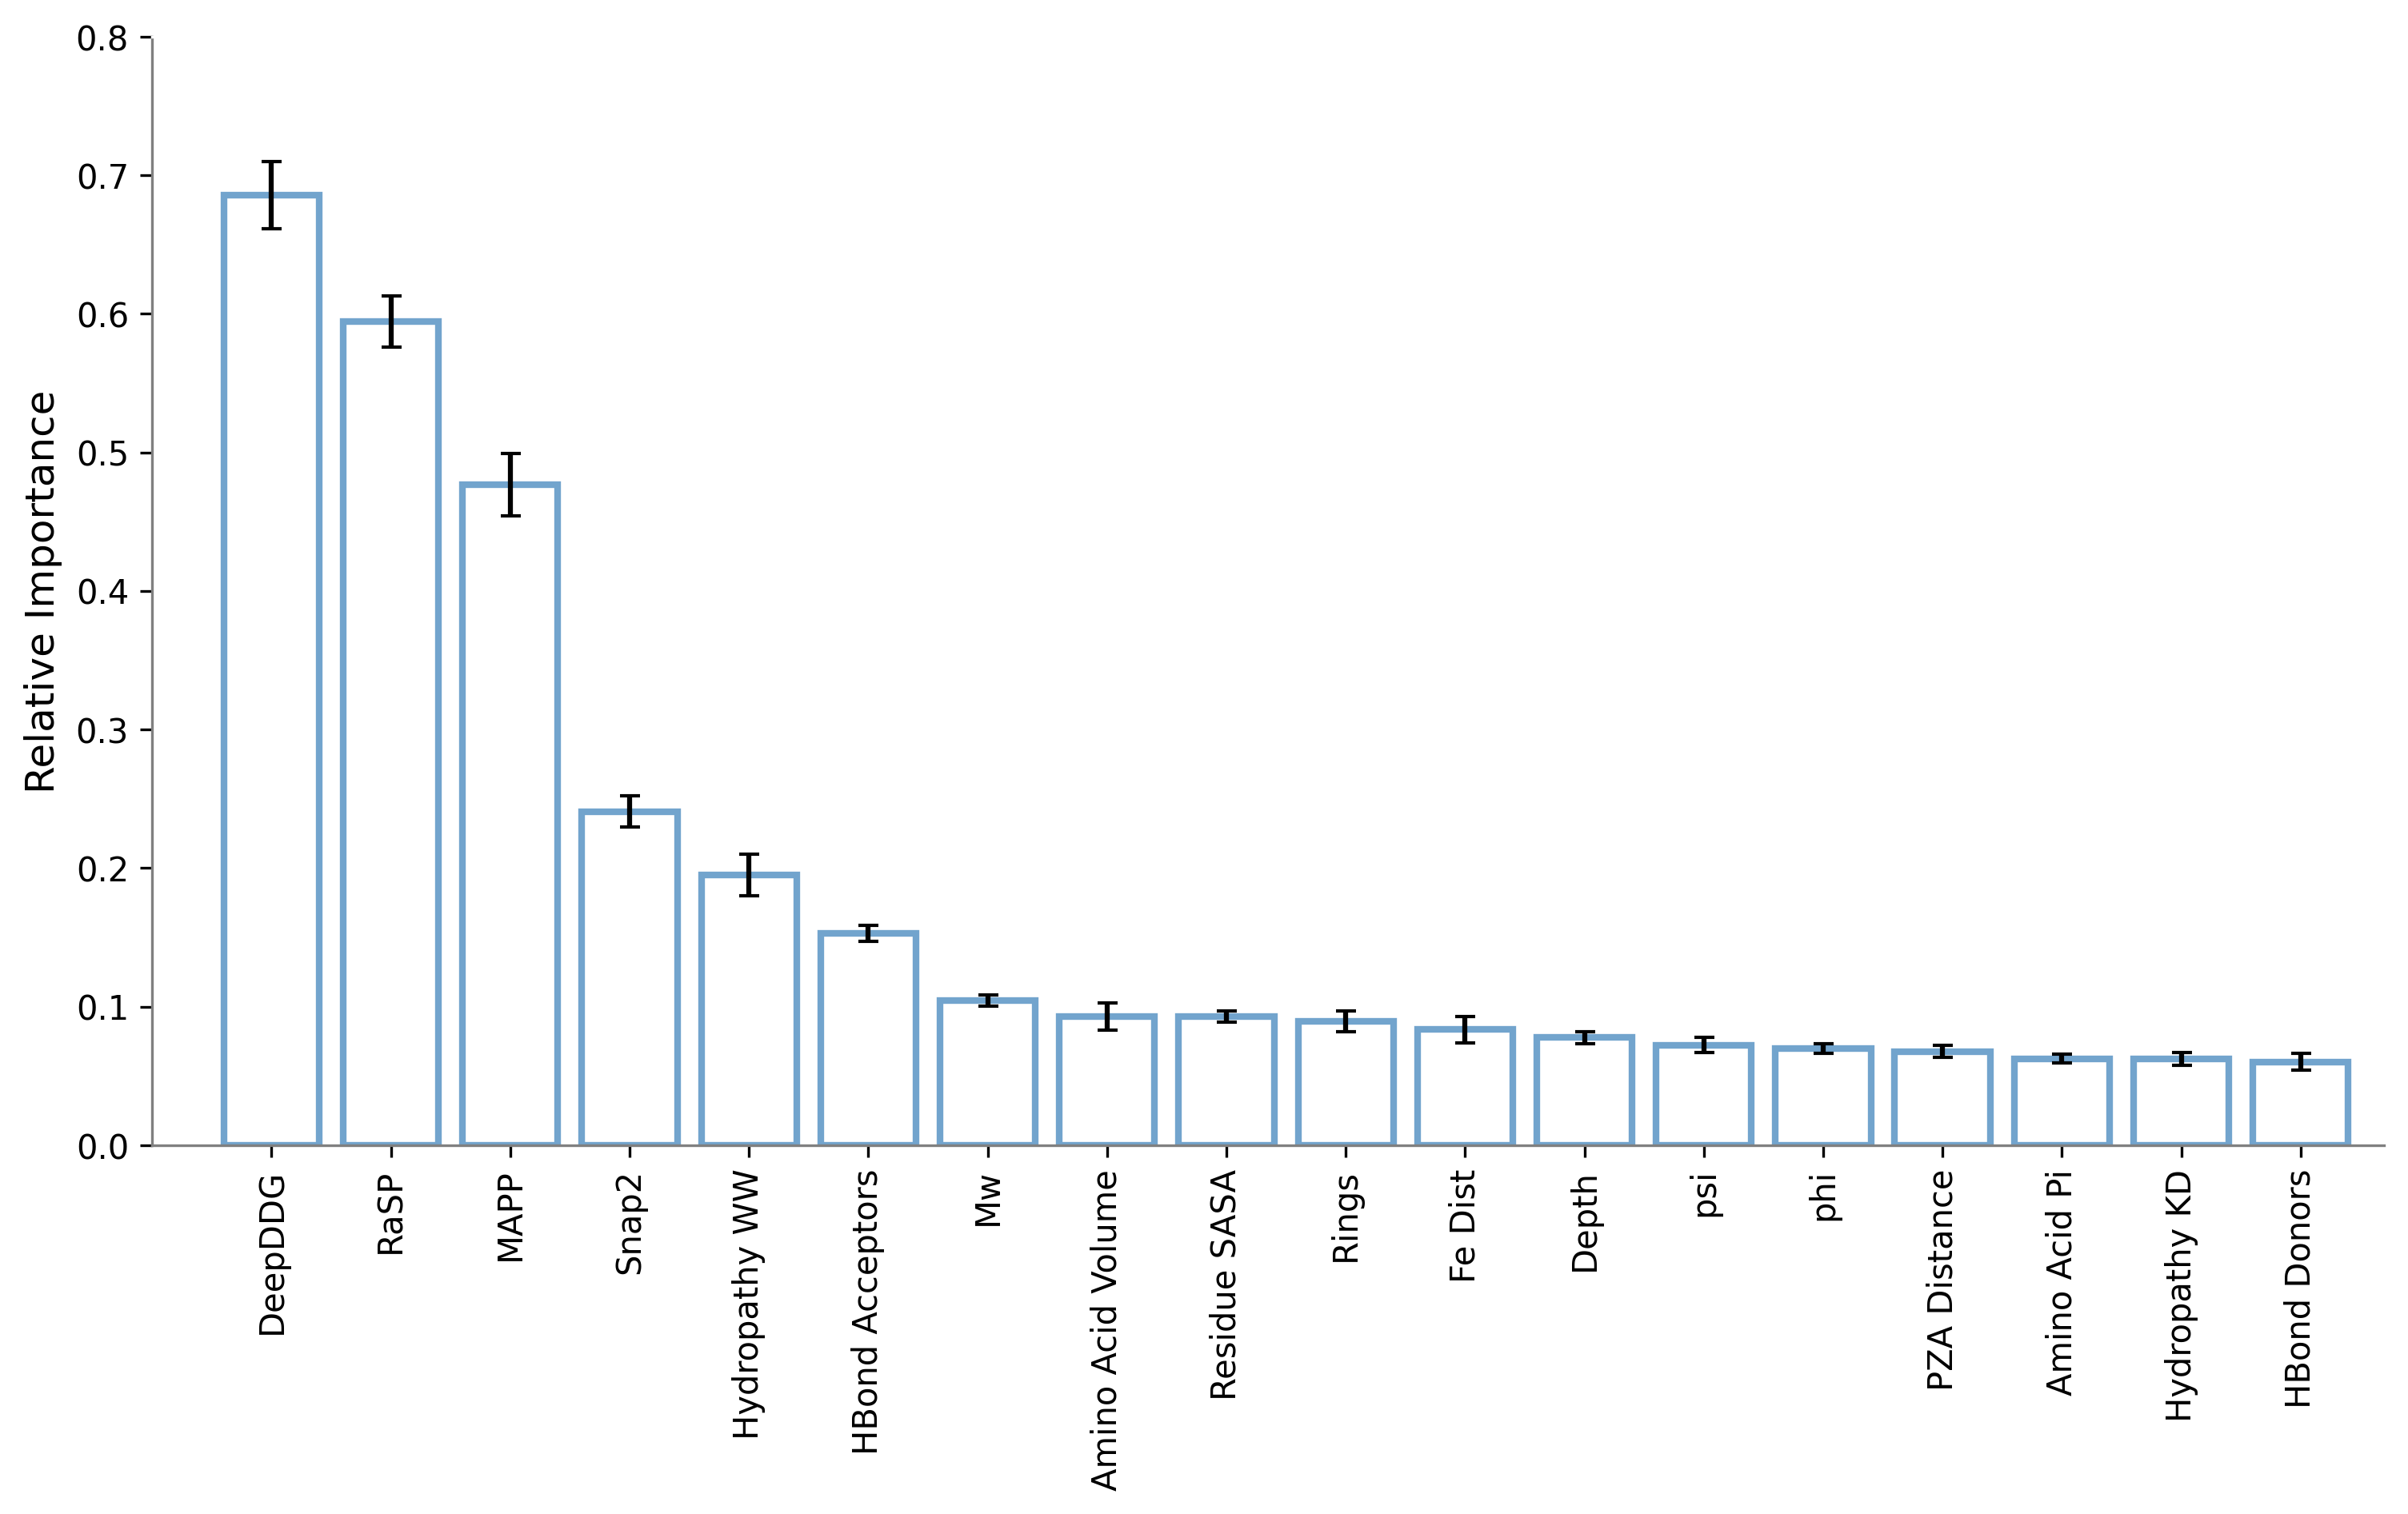

In [9]:
plt.figure(figsize=(12, 6))

plt.errorbar(
    range(len(sorted_means)),
    sorted_means,
    yerr=std_per_feature[sorted_indices],
    fmt='none',
    ecolor='black',
    elinewidth=1.5,
    capsize=3
)
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.xlim(-1, len(sorted_means) - 0.3)
plt.bar(range(len(sorted_means)), sorted_means, 
        alpha=0.7,
        color='white', 
        edgecolor='#377eb8',
        linewidth=2)
plt.ylabel("Relative Importance")
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=90)
plt.show()
